# EDA

In [ ]:
# Add AUC calculation to the existing evaluation
from sklearn.metrics import roc_auc_score

# Calculate AUC (Area Under Curve) for binary classification
try:
    auc = roc_auc_score(gt_bool.flatten(), pred_bool.flatten().astype(float))
    print(f"AUC: {auc:.4f}")
except ValueError:
    # If only one class is present, AUC is undefined
    auc = 0.5
    print(f"AUC: {auc:.4f} (undefined - only one class present)")

# Add AUC to the summary
print(f"\n=== COMPLETE METRICS SUMMARY ===")
print(f"Dice Score: {dice:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")


this file is to conduct EDA for the given data

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import os
from pathlib import Path
from skimage import io, exposure, morphology, measure
from skimage.filters import threshold_otsu, gaussian
from scipy import ndimage
import warnings
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
warnings.filterwarnings('ignore')

In [ ]:
# Set visualization parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

## 1. load and check the image

In [ ]:
# ## Define Data Paths and Load Functions
def setup_paths(base_path):
    """Set up all necessary paths for the project"""
    paths = {
        'base': Path(base_path),
        'train_images': Path(base_path) / 'Data' / 'train_data' / 'image',
        'train_masks': Path(base_path) / 'Data' / 'train_data' / 'ground_truth',
        'val_images': Path(base_path) / 'Data' / 'validation_data' / 'image',
        'val_masks': Path(base_path) / 'Data' / 'validation_data' /'ground_truth',
        'test_images': Path(base_path) / 'Data' / 'test_data' 
    }
    return paths

def load_image(path):
    """Load an image and return as numpy array"""
    if path.suffix.lower() in ['.tif', '.tiff']:
        img = io.imread(str(path))
    else:
        img = np.array(Image.open(path))
    return img

def get_image_list(folder_path, extensions=['.tif', '.tiff']):
    """Get list of image files in a folder"""
    image_files = []
    if folder_path.exists():
        for ext in extensions:
            image_files.extend(list(folder_path.glob(f'*{ext}')))
    return sorted(image_files)

def analyze_dataset_structure(paths):
    """Analyze the structure of the dataset"""
    print("Dataset Structure Analysis")
    print("=" * 50)
    
    for name, path in paths.items():
        if name == 'base':
            continue
        if path.exists():
            files = get_image_list(path)
            print(f"\n{name}:")
            print(f"  Path: {path}")
            print(f"  Number of files: {len(files)}")
            if files:
                print(f"  File examples: {[f.name for f in files[:3]]}")
        else:
            print(f"\n{name}: Path does not exist")

In [ ]:
# change the path here
BASE_PATH = "/home/ygao130/Auto/STOR674/"
paths = setup_paths(BASE_PATH)

In [ ]:
analyze_dataset_structure(paths)

Dataset Structure Analysis

train_images:
  Path: /home/ygao130/Auto/STOR674/Data/train_data/image
  Number of files: 1
  File examples: ['N 134 copy.tif']

train_masks:
  Path: /home/ygao130/Auto/STOR674/Data/train_data/ground_truth
  Number of files: 1
  File examples: ['N 134 groundtruth.tif']

val_images:
  Path: /home/ygao130/Auto/STOR674/Data/validation_data/image
  Number of files: 1
  File examples: ['N129 crop.tif']

val_masks:
  Path: /home/ygao130/Auto/STOR674/Data/validation_data/ground_truth
  Number of files: 1
  File examples: ['N 129 groundtruth.tif']

test_images:
  Path: /home/ygao130/Auto/STOR674/Data/test_data
  Number of files: 7
  File examples: ['p2-from 5-5-2 M.tif', 'p3-from 5-5-2 M.tif', 'p4-from 5-5-2 M.tif']


## 2. EDA: check the training image properties:

### a. shape, data type, min and max values ...

In [6]:
def analyze_image_properties(image_list, sample_size=None):
    """Analyze basic properties of images"""
    if sample_size:
        image_list = image_list[:sample_size]
    
    properties = []
    for img_path in image_list:
        img = load_image(img_path)
        props = {
            'filename': img_path.name,
            'shape': img.shape,
            'dtype': str(img.dtype),
            'min_val': np.min(img),
            'max_val': np.max(img),
            'mean_val': np.mean(img),
            'std_val': np.std(img)
        }
        properties.append(props)
    
    return pd.DataFrame(properties)


train_images = get_image_list(paths['train_images'])
print(train_images)

if train_images:
    props_df = analyze_image_properties(train_images[:5])
    print("\nSample Image Properties:")
    print(props_df.to_string())

[PosixPath('/home/ygao130/Auto/STOR674/Data/train_data/image/N 134 copy.tif')]

Sample Image Properties:
         filename            shape  dtype  min_val  max_val   mean_val   std_val
0  N 134 copy.tif  (4080, 3462, 3)  uint8        0      255  14.761516  31.26379


### b. visualization

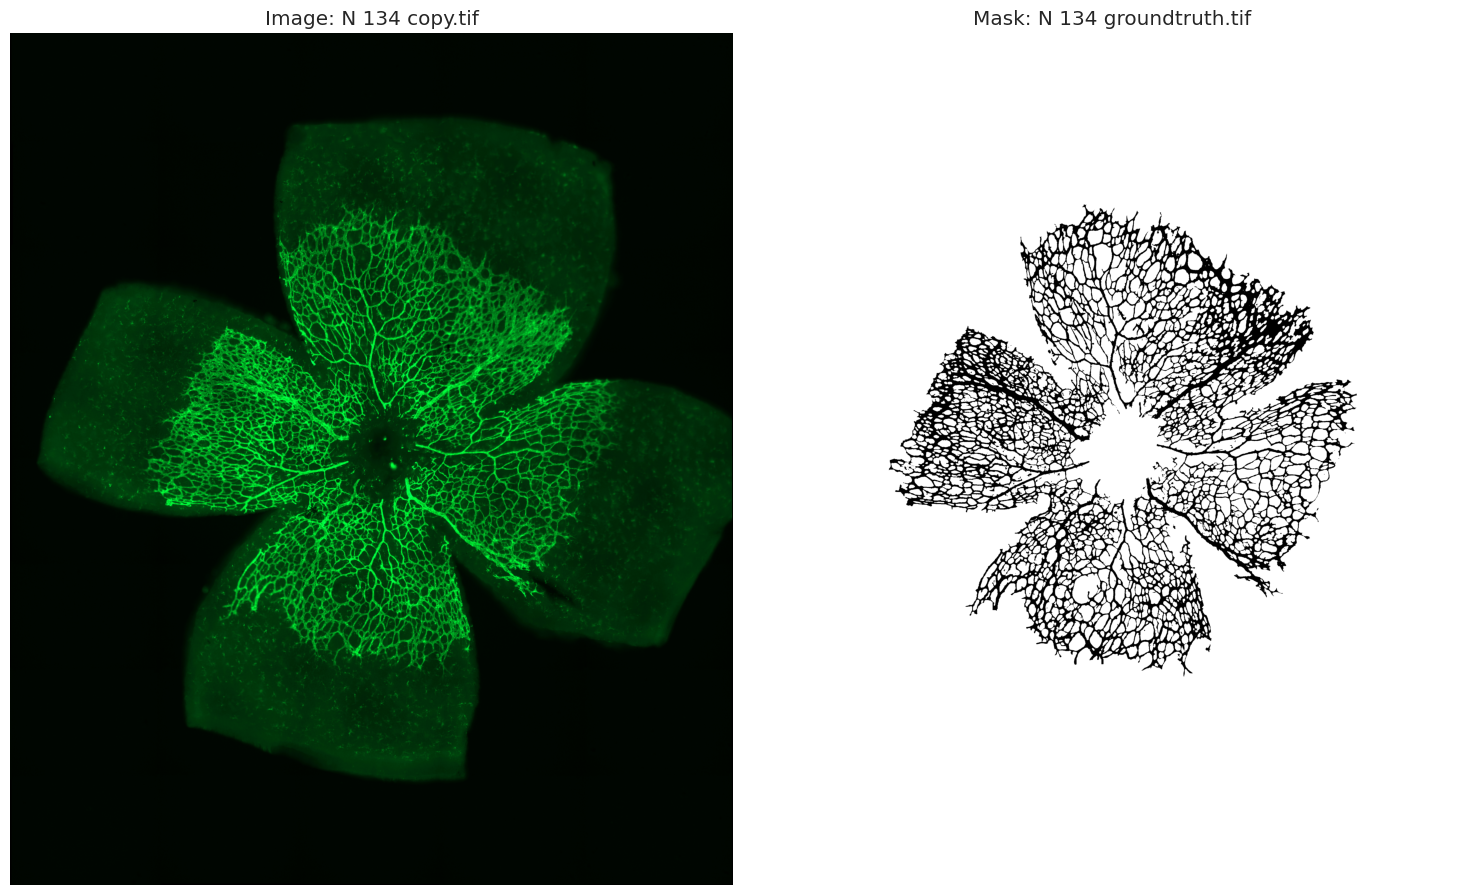

In [ ]:
def visualize_samples(image_paths, mask_paths=None, n_samples=4, figsize=(15, 10)):
    """Visualize sample images and their masks side by side"""
    n_samples = min(n_samples, len(image_paths))
    
    if mask_paths:
        fig, axes = plt.subplots(n_samples, 2, figsize=figsize)
        if n_samples == 1:
            axes = axes.reshape(1, -1)
        
        for i in range(n_samples):
            # Load images
            img = load_image(image_paths[i])
            mask = load_image(mask_paths[i])
            
            # Display image
            axes[i, 0].imshow(img, cmap='gray')
            axes[i, 0].set_title(f'Image: {image_paths[i].name}')
            axes[i, 0].axis('off')
            
            # Display mask
            axes[i, 1].imshow(mask, cmap='gray')
            axes[i, 1].set_title(f'Mask: {mask_paths[i].name}')
            axes[i, 1].axis('off')
    else:
        fig, axes = plt.subplots(1, n_samples, figsize=figsize)
        if n_samples == 1:
            axes = [axes]
        
        for i in range(n_samples):
            img = load_image(image_paths[i])
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'{image_paths[i].name}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

train_images = get_image_list(paths['train_images'])
train_masks = get_image_list(paths['train_masks'])
visualize_samples(train_images, train_masks, n_samples=1)

[PosixPath('/home/ygao130/Auto/STOR674/Data/train_data/image/N 134 copy.tif')]


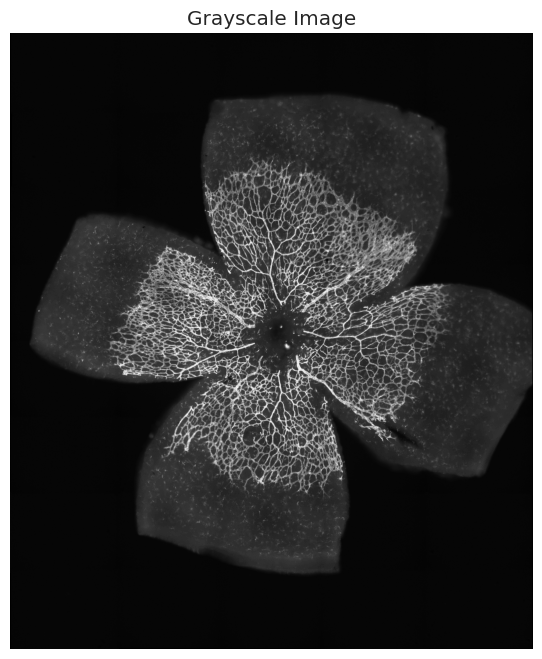

In [71]:
# convert the image to grayscale:
train_images = get_image_list(paths['train_images'])
print(train_images)
img = Image.open(train_images[0])
gray_img = img.convert('L')   # “L” = (8-bit) grayscale mode
gray_img_array = np.array(gray_img)

plt.imshow(gray_img_array, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

### c. check image intensity distribution

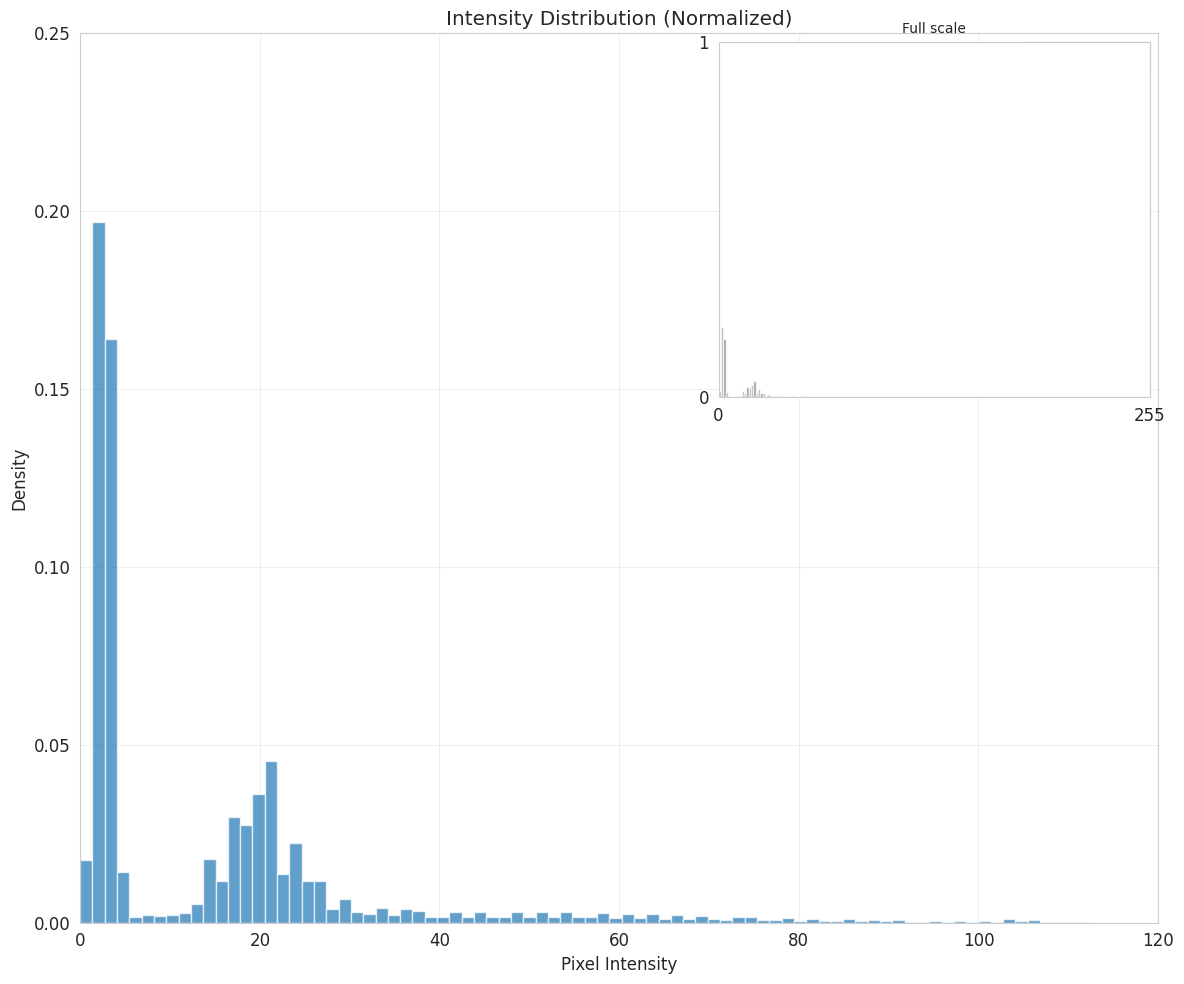

In [ ]:
def visualize_intensity_distribution(image_paths, n_samples=5):
    """Visualize intensity adistributions of sample images"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    for i in range(min(n_samples, len(image_paths))):
        img = load_image(image_paths[i])
        # Convert to grayscale if color image
        if len(img.shape) == 3:
            img = np.mean(img, axis=2)
        
        ax.hist(img.flatten(), bins=100, alpha=0.7, 
                label=f'Image {i+1}', density=True)
    
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Density')
    ax.set_title('Intensity Distribution (Normalized)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # can comment this out to only plot intensity
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 0.25)
    # Inset for full range
    axins = inset_axes(ax, width="40%", height="40%", loc='upper right')
    axins.hist(img.flatten(), bins=100, density=True, color='gray', alpha=0.7)
    axins.set_xlim(0, 255)
    axins.set_ylim(0, 1)
    axins.set_xticks([0, 255])
    axins.set_yticks([0, 1])
    axins.set_title("Full scale", fontsize=10)


    plt.tight_layout()    
    plt.show()

train_images = get_image_list(paths['train_images'])
train_masks = get_image_list(paths['train_masks'])
visualize_intensity_distribution(train_images, n_samples=1)

### d. Spatial Analysis by Rings

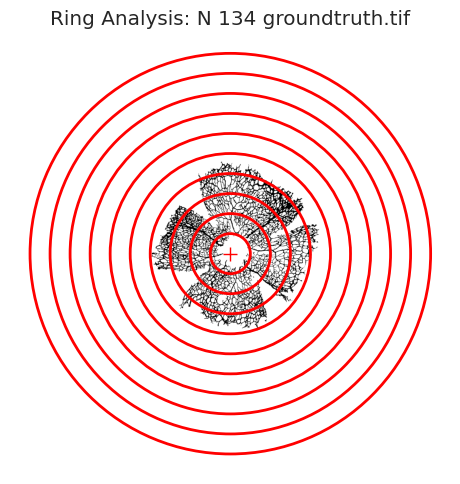

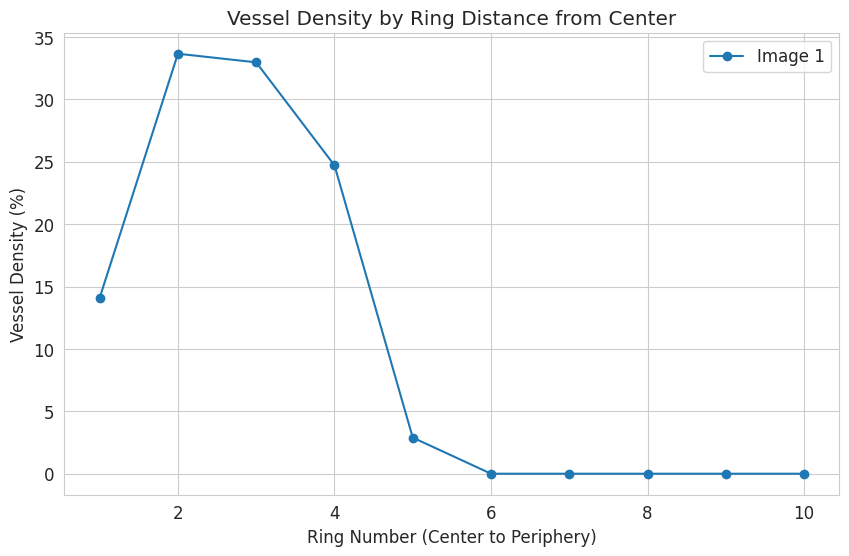

In [25]:
# ## Spatial Analysis

def analyze_spatial_distribution(mask_paths, n_samples=3, n_rings=10):
    """Analyze spatial distribution of vessels using ring-based approach"""
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))
    if n_samples == 1:
        axes = [axes]
    
    ring_stats = []
    
    for idx, mask_path in enumerate(mask_paths[:n_samples]):
        mask = load_image(mask_path)
        if len(np.unique(mask)) > 2:
            mask = (mask > threshold_otsu(mask)).astype(np.uint8)
        
        # Find center of mass
        center = ndimage.center_of_mass(mask)
        h, w = mask.shape[:2]
        
        # Create rings
        y, x = np.ogrid[:h, :w]
        dist_from_center = np.sqrt((x - center[1])**2 + (y - center[0])**2)
        max_dist = np.max(dist_from_center)
        
        # Calculate vessel density in each ring
        ring_densities = []
        ring_boundaries = np.linspace(0, max_dist, n_rings + 1)
        
        for i in range(n_rings):
            ring_mask = (dist_from_center >= ring_boundaries[i]) & \
                       (dist_from_center < ring_boundaries[i + 1])
            # if np.sum(ring_mask) > 0:
            #     density = np.sum(mask[ring_mask]) / np.sum(ring_mask) * 100
            # else:
            #     density = 0
            if mask.dtype == bool:
                density = np.sum(~mask[ring_mask]) / np.sum(ring_mask) * 100  # False = vessels
            else:
                density = np.sum(mask[ring_mask]) / np.sum(ring_mask) * 100
            
            ring_densities.append(density)
        
        ring_stats.append(ring_densities)
        
        # Visualize
        axes[idx].imshow(mask, cmap='gray')
        for i in range(n_rings):
            circle = plt.Circle(center[::-1], ring_boundaries[i+1], 
                              fill=False, color='red', linewidth=2)
            axes[idx].add_patch(circle)
        axes[idx].plot(center[1], center[0], 'r+', markersize=10)
        axes[idx].set_title(f'Ring Analysis: {mask_path.name}')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Plot ring densities
    fig, ax = plt.subplots(figsize=(10, 6))
    ring_stats = np.array(ring_stats)
    x = range(1, n_rings + 1)
    
    for i in range(len(ring_stats)):
        ax.plot(x, ring_stats[i], marker='o', label=f'Image {i+1}')
    
    ax.set_xlabel('Ring Number (Center to Periphery)')
    ax.set_ylabel('Vessel Density (%)')
    ax.set_title('Vessel Density by Ring Distance from Center')
    ax.legend()
    ax.grid(True)
    plt.show()
    
    return ring_stats

train_images = get_image_list(paths['train_images'])
train_masks = get_image_list(paths['train_masks'])
ring_stats = analyze_spatial_distribution(train_masks, n_samples=1)

### e. different preprocessing

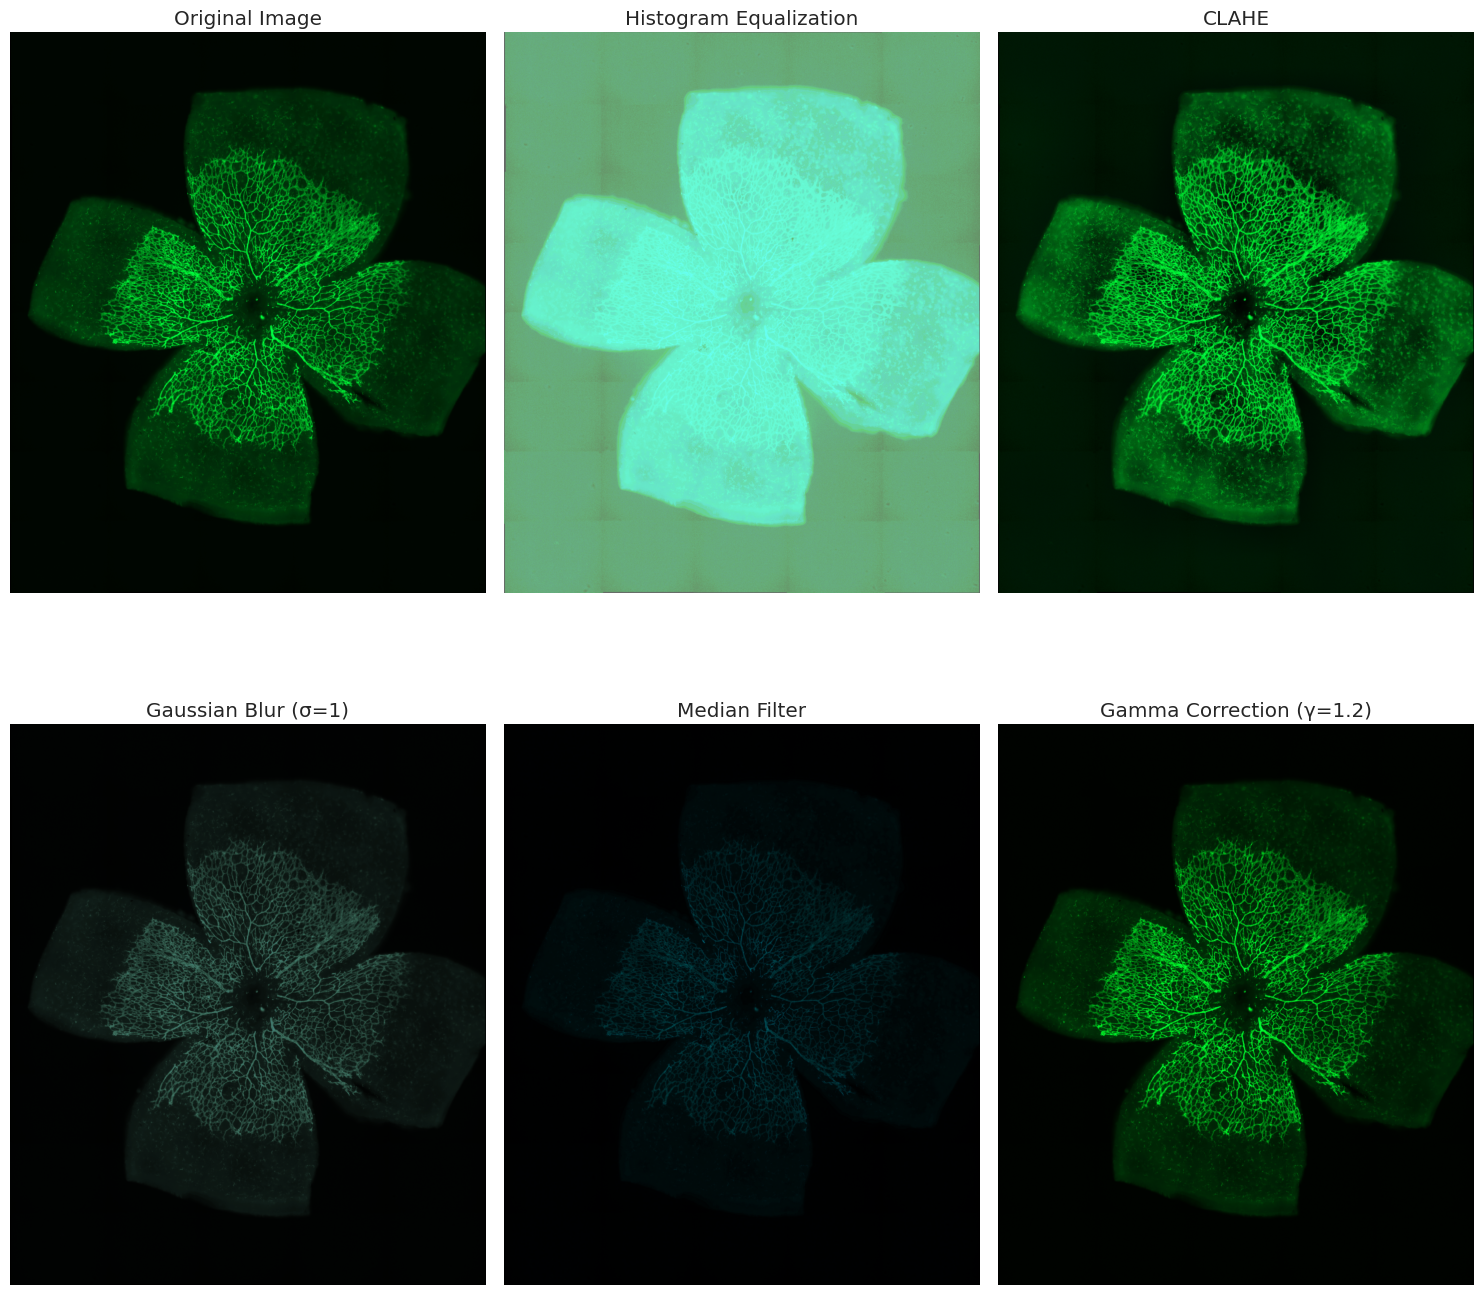

In [ ]:
# ## Preprocessing Analysis

def analyze_preprocessing_effects(image_path, mask_path):
    """Analyze effects of different preprocessing techniques"""
    img = load_image(image_path)
    mask = load_image(mask_path)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 15))
    
    # Original
    axes[0, 0].imshow(img, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Histogram equalization
    img_eq = exposure.equalize_hist(img)
    axes[0, 1].imshow(img_eq, cmap='gray')
    axes[0, 1].set_title('Histogram Equalization')
    axes[0, 1].axis('off')
    
    # CLAHE
    img_clahe = exposure.equalize_adapthist(img, clip_limit=0.03)
    axes[0, 2].imshow(img_clahe, cmap='gray')
    axes[0, 2].set_title('CLAHE')
    axes[0, 2].axis('off')
    
    # Gaussian blur
    img_blur = gaussian(img, sigma=1)
    axes[1, 0].imshow(img_blur, cmap='gray')
    axes[1, 0].set_title('Gaussian Blur (σ=1)')
    axes[1, 0].axis('off')
    
    # Median filter
    img_median = ndimage.median_filter(img, size=3)
    axes[1, 1].imshow(img_median, cmap='gray')
    axes[1, 1].set_title('Median Filter')
    axes[1, 1].axis('off')
    
    # Gamma correction
    img_gamma = exposure.adjust_gamma(img, gamma=1.2)
    axes[1, 2].imshow(img_gamma, cmap='gray')
    axes[1, 2].set_title('Gamma Correction (γ=1.2)')
    axes[1, 2].axis('off')
    
    # # Edge detection
    # img_edges = cv2.Canny((img * 255).astype(np.uint8), 50, 150)
    # axes[2, 0].imshow(img_edges, cmap='gray')
    # axes[2, 0].set_title('Edge Detection (Canny)')
    # axes[2, 0].axis('off')
    
    # # Ground truth mask
    # axes[2, 1].imshow(mask, cmap='gray')
    # axes[2, 1].set_title('Ground Truth Mask')
    # axes[2, 1].axis('off')
    
    # # Overlay
    # overlay = np.zeros((*img.shape[:2], 3))
    # overlay[:,:,0] = img / np.max(img)
    # overlay[:,:,1] = mask / np.max(mask)
    # axes[2, 2].imshow(overlay)
    # axes[2, 2].set_title('Overlay (Red: Image, Green: Mask)')
    # axes[2, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


train_images = get_image_list(paths['train_images'])
train_masks = get_image_list(paths['train_masks'])

analyze_preprocessing_effects(train_images[0], train_masks[0])

### f. iamge mask analysis: Mask dtype, Pixel value distribution ...

In [13]:
# COMPREHENSIVE MASK ANALYSIS
def analyze_mask_detailed(mask_path):
    """Comprehensive analysis of mask properties"""
    mask = load_image(mask_path)
    
    print("=== COMPREHENSIVE MASK ANALYSIS ===")
    print(f"Mask shape: {mask.shape}")
    print(f"Mask dtype: {mask.dtype}")
    print(f"Unique values: {np.unique(mask)}")
    print(f"Number of unique values: {len(np.unique(mask))}")
    print(f"Min value: {np.min(mask)}")
    print(f"Max value: {np.max(mask)}")
    print(f"Mean value: {np.mean(mask):.2f}")
    print(f"Median value: {np.median(mask):.2f}")
    print(f"Std value: {np.std(mask):.2f}")
    
    # Count pixels by value
    unique_vals, counts = np.unique(mask, return_counts=True)
    print(f"\nPixel value distribution:")
    for val, count in zip(unique_vals, counts):
        percentage = (count / mask.size) * 100
        print(f"  Value {val}: {count} pixels ({percentage:.2f}%)")
    
    
    return mask

# Run the analysis
train_masks = get_image_list(paths['train_masks'])
mask = analyze_mask_detailed(train_masks[0])

=== COMPREHENSIVE MASK ANALYSIS ===
Mask shape: (4080, 3462)
Mask dtype: bool
Unique values: [False  True]
Number of unique values: 2
Min value: False
Max value: True
Mean value: 0.92
Median value: 1.00
Std value: 0.27

Pixel value distribution:
  Value False: 1085788 pixels (7.69%)
  Value True: 13039172 pixels (92.31%)


### g. Patch Analysis for Training

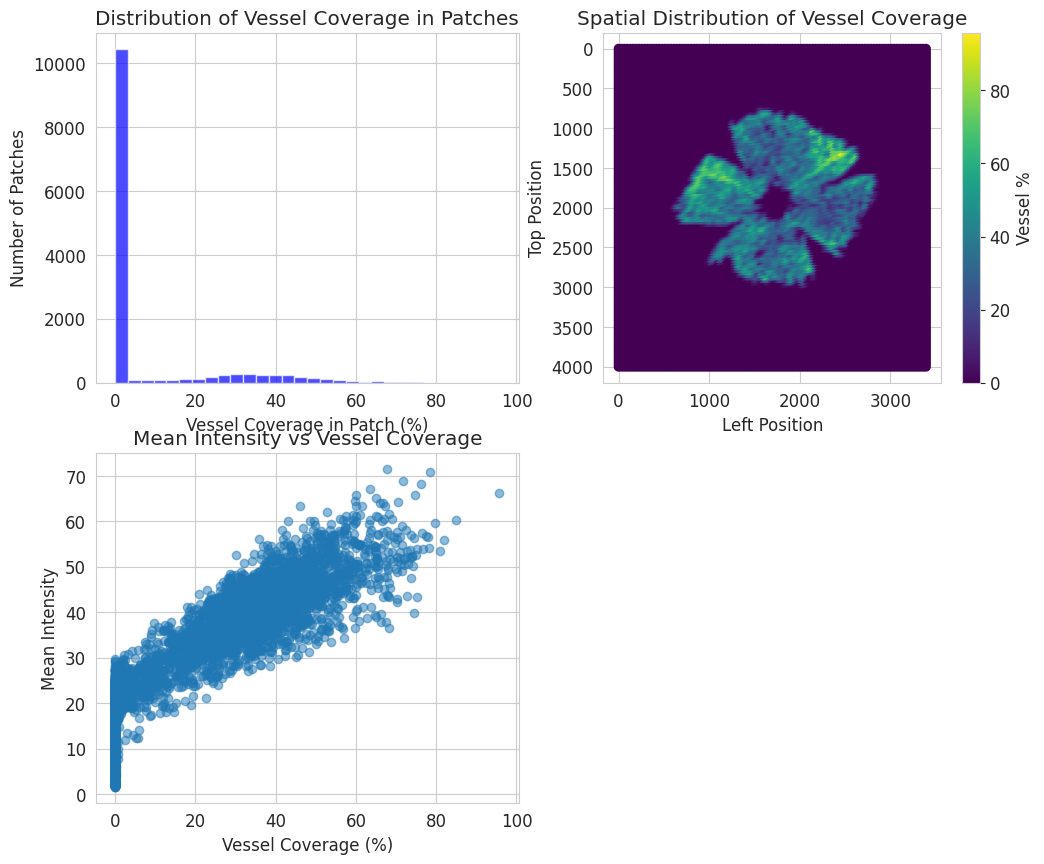

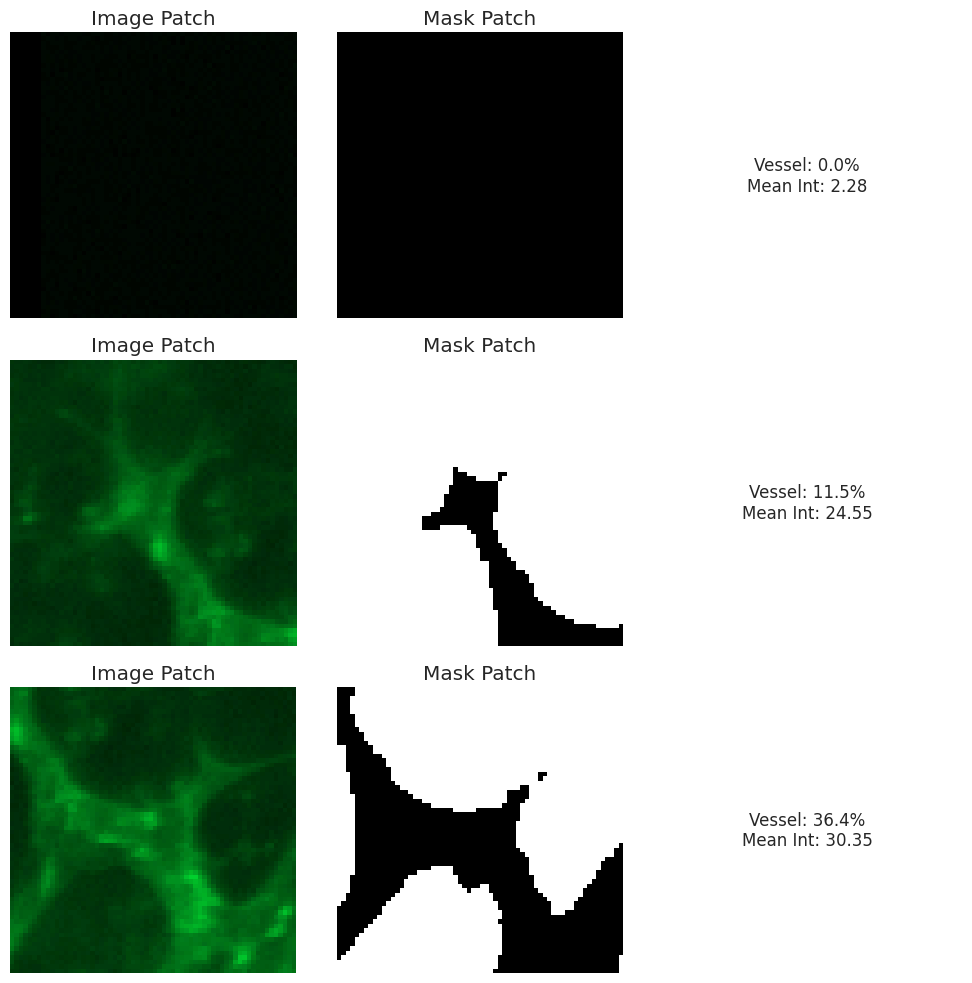


Total patches extracted: 13482
Patches with >10% vessels: 2864
Patches with >20% vessels: 2550


In [ ]:
# ## Patch Analysis for Training

def analyze_patch_distribution(image_path, mask_path, patch_size=64, stride=32):
    """Analyze patch extraction for training"""
    img = load_image(image_path)
    mask = load_image(mask_path)
    
    h, w = img.shape[:2]
    patches_info = []
    
    # Extract patches
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch_img = img[i:i+patch_size, j:j+patch_size]
            patch_mask = mask[i:i+patch_size, j:j+patch_size]
            
            # Calculate vessel percentage in patch
            if patch_mask.dtype == bool:
                vessel_percent = np.sum(~patch_mask) / patch_mask.size * 100  # False = vessels
            elif np.mean(patch_mask) < 128:
                vessel_percent = np.sum(patch_mask > 0) / patch_mask.size * 100
            else:
                vessel_percent = np.sum(patch_mask == 0) / patch_mask.size * 100
            
            patches_info.append({
                'top': i,
                'left': j,
                'vessel_percent': vessel_percent,
                'mean_intensity': np.mean(patch_img),
                'std_intensity': np.std(patch_img)
            })
    
    patches_df = pd.DataFrame(patches_info)
    
    # Visualize patch statistics
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Vessel percentage distribution
    axes[0, 0].hist(patches_df['vessel_percent'], bins=30, color='blue', alpha=0.7)
    axes[0, 0].set_xlabel('Vessel Coverage in Patch (%)')
    axes[0, 0].set_ylabel('Number of Patches')
    axes[0, 0].set_title('Distribution of Vessel Coverage in Patches')
    
    # Scatter plot of vessel percentage vs position
    scatter = axes[0, 1].scatter(patches_df['left'], patches_df['top'], 
                                c=patches_df['vessel_percent'], cmap='viridis')
    axes[0, 1].set_xlabel('Left Position')
    axes[0, 1].set_ylabel('Top Position')
    axes[0, 1].set_title('Spatial Distribution of Vessel Coverage')
    axes[0, 1].invert_yaxis()
    plt.colorbar(scatter, ax=axes[0, 1], label='Vessel %')
    
    # Mean intensity vs vessel percentage
    axes[1, 0].scatter(patches_df['vessel_percent'], patches_df['mean_intensity'], alpha=0.5)
    axes[1, 0].set_xlabel('Vessel Coverage (%)')
    axes[1, 0].set_ylabel('Mean Intensity')
    axes[1, 0].set_title('Mean Intensity vs Vessel Coverage')
    
    # Example patches
    ax = axes[1, 1]
    ax.axis('off')
    
    # Show some example patches
    n_examples = 9
    example_indices = [
        patches_df[patches_df['vessel_percent'] < 5].index[0] if len(patches_df[patches_df['vessel_percent'] < 5]) > 0 else 0,  # Low vessel
        patches_df[(patches_df['vessel_percent'] > 10) & (patches_df['vessel_percent'] < 20)].index[0] if len(patches_df[(patches_df['vessel_percent'] > 10) & (patches_df['vessel_percent'] < 20)]) > 0 else 1,  # Medium vessel
        patches_df[patches_df['vessel_percent'] > 25].index[0] if len(patches_df[patches_df['vessel_percent'] > 25]) > 0 else 2  # High vessel
    ]
    
    fig2, axes2 = plt.subplots(len(example_indices), 3, figsize=(10, 10))
    for idx, patch_idx in enumerate(example_indices):
        patch_info = patches_df.iloc[patch_idx]
        i, j = int(patch_info['top']), int(patch_info['left'])
        
        patch_img = img[i:i+patch_size, j:j+patch_size]
        patch_mask = mask[i:i+patch_size, j:j+patch_size]
        
        axes2[idx, 0].imshow(patch_img, cmap='gray')
        axes2[idx, 0].set_title(f'Image Patch')
        axes2[idx, 0].axis('off')
        
        axes2[idx, 1].imshow(patch_mask, cmap='gray')
        axes2[idx, 1].set_title(f'Mask Patch')
        axes2[idx, 1].axis('off')
        
        axes2[idx, 2].text(0.5, 0.5, f'Vessel: {patch_info["vessel_percent"]:.1f}%\nMean Int: {patch_info["mean_intensity"]:.2f}', 
                          ha='center', va='center', fontsize=12)
        axes2[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return patches_df

train_images = get_image_list(paths['train_images'])
train_masks = get_image_list(paths['train_masks'])

patches_df = analyze_patch_distribution(train_images[0], train_masks[0])
print(f"\nTotal patches extracted: {len(patches_df)}")
print(f"Patches with >10% vessels: {len(patches_df[patches_df['vessel_percent'] > 10])}")
print(f"Patches with >20% vessels: {len(patches_df[patches_df['vessel_percent'] > 20])}")

## 3. data convertion: specific for validation mask image

the original given mask for validation data has 0-255 scale (unique value: [0,255]), here we need to convert the mask to Boolean dtype for later model traning and feature extraction.

Original array shape: (3000, 3000)
Original data type: uint8
Original unique values: [  0 255]
Converted array shape: (3000, 3000)
Converted data type: bool
Converted unique values: [False  True]
Total pixels: 9000000
Number of False values: 7411090 (82.35%)
Number of True values: 1588910 (17.65%)
Converted image saved to: /home/ygao130/Auto/STOR674/Data/validation_data/ground_truth/N 129 groundtruth_converted.tif
Verification - Loaded array shape: (3000, 3000)
Verification - Loaded array dtype: uint8
Verification - Loaded unique values: [0 1]
Verification - Arrays are equal: True


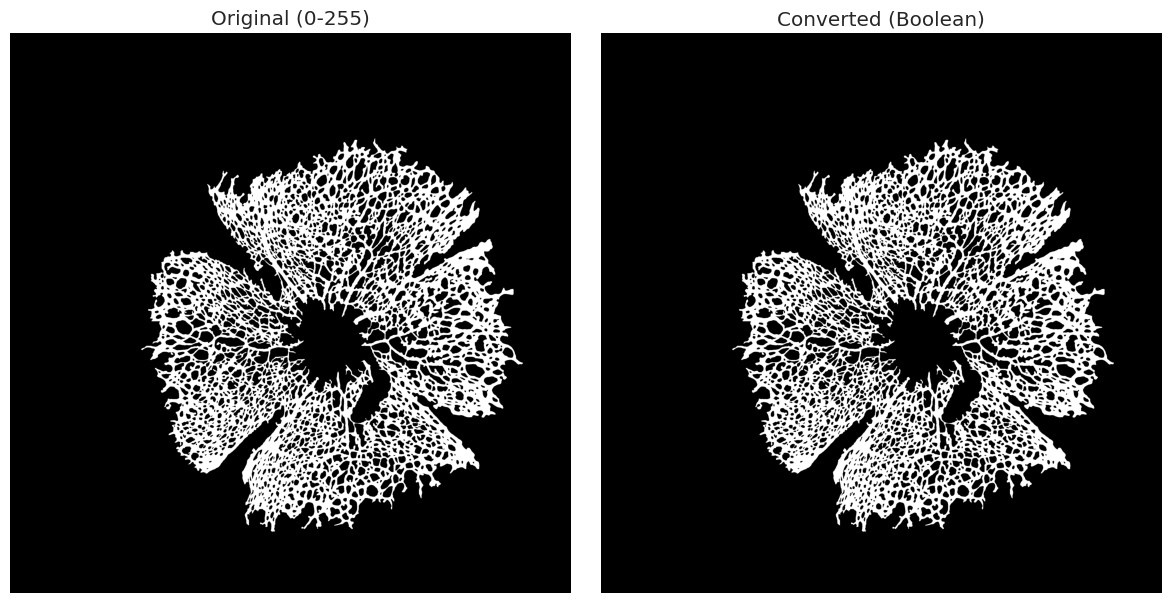

In [ ]:
# for validation mask tif: 
# Convert 0-255 values to 0-1 based on threshold of 128
# Load the image
img = Image.open('/home/ygao130/Auto/STOR674/Data/validation_data/_old/N 129 groundtruth.tif')
gray_img_array = np.array(img)

print(f"Original array shape: {gray_img_array.shape}")
print(f"Original data type: {gray_img_array.dtype}")
print(f"Original unique values: {np.unique(gray_img_array)}")

# Convert to boolean based on threshold of 128
# Values >= 128 become True, values < 128 become False
converted_array = (gray_img_array >= 128)

print(f"Converted array shape: {converted_array.shape}")
print(f"Converted data type: {converted_array.dtype}")
print(f"Converted unique values: {np.unique(converted_array)}")

# Count the converted values
false_count = np.sum(~converted_array)  # Count False values
true_count = np.sum(converted_array)    # Count True values
total_pixels = converted_array.size
print(f"Total pixels: {total_pixels}")
print(f"Number of False values: {false_count} ({(false_count/total_pixels)*100:.2f}%)")
print(f"Number of True values: {true_count} ({(true_count/total_pixels)*100:.2f}%)")

# Save the converted image (convert boolean to uint8 for saving)
output_path = '/home/ygao130/Auto/STOR674/Data/validation_data/ground_truth/N 129 groundtruth_converted.tif'
converted_img = Image.fromarray(converted_array.astype(np.uint8))
converted_img.save(output_path)

print(f"Converted image saved to: {output_path}")

# Verify the saved image by loading it back
loaded_converted = np.array(Image.open(output_path))
print(f"Verification - Loaded array shape: {loaded_converted.shape}")
print(f"Verification - Loaded array dtype: {loaded_converted.dtype}")
print(f"Verification - Loaded unique values: {np.unique(loaded_converted)}")
print(f"Verification - Arrays are equal: {np.array_equal(converted_array, loaded_converted)}")

# Display both images side by side for comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(gray_img_array, cmap='gray')
axes[0].set_title('Original (0-255)')
axes[0].axis('off')

# Converted image
axes[1].imshow(converted_array, cmap='gray')
axes[1].set_title('Converted (Boolean)')
axes[1].axis('off')

plt.tight_layout()
plt.show()


# after trianing: calculate DICE

In [ ]:
# check the pixial value distribution for mask 
img = Image.open('/home/ygao130/Auto/STOR674/Data/validation_data/ground_truth/N 129 groundtruth_converted.tif')
arr = np.array(img)
bool_arr = arr > 0

# Count True and False values
true_count = np.count_nonzero(bool_arr)
false_count = np.count_nonzero(~bool_arr)
total_pixels = bool_arr.size

print(f"Number of True values (vessels): {true_count}")
print(f"Number of False values (background): {false_count}")
print(f"Total pixels: {total_pixels}")
print(f"Percentage of True values: {true_count / total_pixels * 100:.2f}%")
print(f"Percentage of False values: {false_count / total_pixels * 100:.2f}%")


Number of True values (vessels): 1588910
Number of False values (background): 7411090
Total pixels: 9000000
Percentage of True values: 17.65%
Percentage of False values: 82.35%


In [ ]:
# Count True and False values in the boolean array
# true_count = np.sum(gray_img_array)  # Counts True values (1s)

img = Image.open('/home/ygao130/Auto/STOR674/scripts/01-segmentation/nnUnet/nnUNet_results/Dataset001_vessel/nnUNetTrainer_50epochs__nnUNetResEncUNetLPlans__2d/predictions/vessel_001.tif')
gray_img_array = np.array(img)
loaded_array = gray_img_array

bool_array = gray_img_array.astype(np.bool_)
true_count = np.sum(~bool_array)  
false_count = np.sum(bool_array) 
total_pixels = bool_array.size


# true_count = np.count_nonzero(gray_img_array)
# false_count = np.sum(gray_img_array == 0)
print(f"total added: {true_count + false_count}")


print(f"Number of True values (1s): {true_count}")
print(f"Number of False values (0s): {false_count}")
print(f"Total pixels: {total_pixels}")
print(f"Percentage of True values: {(true_count/total_pixels)*100:.2f}%")
print(f"Percentage of False values: {(false_count/total_pixels)*100:.2f}%")

# Alternative method using np.count_nonzero
true_count_alt = np.count_nonzero(gray_img_array)
false_count_alt = np.count_nonzero(~gray_img_array)

print(f"\nAlternative counting method:")
print(f"True values (np.count_nonzero): {true_count_alt}")
print(f"False values (np.count_nonzero of ~array): {false_count_alt}")

# Using np.unique to get counts
unique_values, counts = np.unique(gray_img_array, return_counts=True)
print(f"\nUsing np.unique:")
for value, count in zip(unique_values, counts):
    print(f"Value {value}: {count} pixels ({(count/total_pixels)*100:.2f}%)")

total added: 9000000
Number of True values (1s): 1089258
Number of False values (0s): 7910742
Total pixels: 9000000
Percentage of True values: 12.10%
Percentage of False values: 87.90%

Alternative counting method:
True values (np.count_nonzero): 7910742
False values (np.count_nonzero of ~array): 9000000

Using np.unique:
Value 0: 1089258 pixels (12.10%)
Value 1: 7910742 pixels (87.90%)


Ground Truth shape: (3000, 3000), dtype: uint8, unique: [0 1]
Prediction shape: (3000, 3000), dtype: uint8, unique: [0 1]

=== DICE SCORE CALCULATION ===
Dice Score: 0.8080
Dice Score (%): 80.80%

=== DETAILED METRICS ===
Ground Truth positives: 1588910
Prediction positives: 1116417
Intersection: 1092956
Union: 2705327

=== OTHER METRICS ===
Precision: 0.9790
Recall: 0.6879
F1-Score: 0.8080


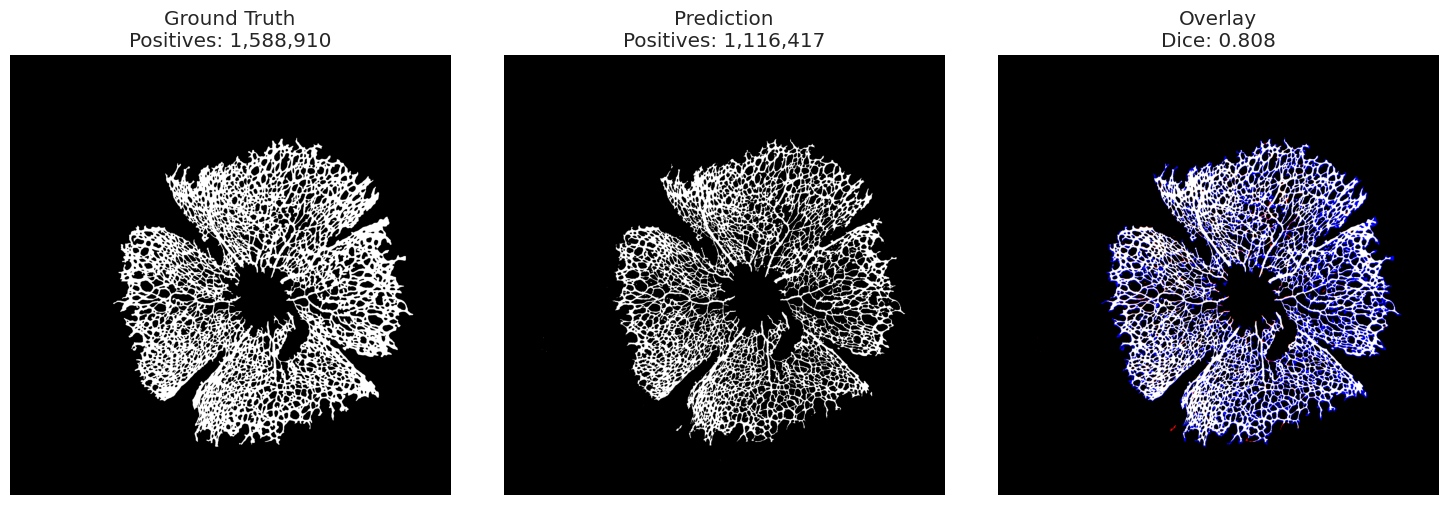


=== CONFUSION MATRIX STYLE ===
True Positives (TP): 1,092,956
False Positives (FP): 23,461
False Negatives (FN): 495,954
True Negatives (TN): 7,387,629


In [31]:
# Calculate Dice Score between Ground Truth and Prediction

# Load both images
ground_truth_path = '/home/ygao130/Auto/STOR674/Data/validation_data/ground_truth/N 129 groundtruth_converted.tif'
# prediction_path = '/home/ygao130/Auto/STOR674/scripts/01-segmentation/nnUnet/nnUNet_results/Dataset001_vessel/nnUNetTrainer_50epochs__nnUNetResEncUNetLPlans__2d/predictions/vessel_001.tif'
# prediction_path = '/home/ygao130/Auto/STOR674/scripts/01-segmentation/nnUnet/nnUNet_results/Dataset001_vessel/nnUNetTrainer_100epochs__nnUNetResEncUNetLPlans__2d/predictions/vessel_001.tif'
prediction_path = '/home/ygao130/Auto/STOR674/Data/validation_data/feature_extraction/img/N_129_predicted.tif'
# Load ground truth
gt_img = Image.open(ground_truth_path)
gt_array = np.array(gt_img)

# Load prediction
pred_img = Image.open(prediction_path)
pred_array = np.array(pred_img)

print(f"Ground Truth shape: {gt_array.shape}, dtype: {gt_array.dtype}, unique: {np.unique(gt_array)}")
print(f"Prediction shape: {pred_array.shape}, dtype: {pred_array.dtype}, unique: {np.unique(pred_array)}")

# Convert both to boolean for Dice calculation
gt_bool = gt_array.astype(np.bool_)
pred_bool = pred_array.astype(np.bool_)
# Calculate Dice Score
def dice_score(y_true, y_pred):
    """
    Calculate Dice score between two binary arrays
    Dice = 2 * |A ∩ B| / (|A| + |B|)
    """
    intersection = np.sum(y_true & y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    
    if union == 0:
        return 1.0  # Both arrays are all zeros
    
    dice = (2.0 * intersection) / union
    return dice

# Calculate Dice score
dice = dice_score(gt_bool, pred_bool)

print(f"\n=== DICE SCORE CALCULATION ===")
print(f"Dice Score: {dice:.4f}")
print(f"Dice Score (%): {dice*100:.2f}%")

# Additional metrics
intersection = np.sum(gt_bool & pred_bool)
gt_positive = np.sum(gt_bool)
pred_positive = np.sum(pred_bool)

print(f"\n=== DETAILED METRICS ===")
print(f"Ground Truth positives: {gt_positive}")
print(f"Prediction positives: {pred_positive}")
print(f"Intersection: {intersection}")
print(f"Union: {gt_positive + pred_positive}")

# Calculate other common metrics
precision = intersection / pred_positive if pred_positive > 0 else 0
recall = intersection / gt_positive if gt_positive > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n=== OTHER METRICS ===")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


# Visualize Ground Truth vs Prediction

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Ground Truth
axes[0].imshow(gt_bool, cmap='gray')
axes[0].set_title(f'Ground Truth\nPositives: {np.sum(gt_bool):,}')
axes[0].axis('off')

# Prediction
axes[1].imshow(pred_bool, cmap='gray')
axes[1].set_title(f'Prediction\nPositives: {np.sum(pred_bool):,}')
axes[1].axis('off')

# Overlay (True Positives in white, False Positives in red, False Negatives in blue)
overlay = np.zeros((gt_bool.shape[0], gt_bool.shape[1], 3))
overlay[gt_bool & pred_bool] = [1, 1, 1]  # True Positives: white
overlay[~gt_bool & pred_bool] = [1, 0, 0]  # False Positives: red
overlay[gt_bool & ~pred_bool] = [0, 0, 1]  # False Negatives: blue

axes[2].imshow(overlay)
axes[2].set_title(f'Overlay\nDice: {dice:.3f}')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Print confusion matrix style summary
print(f"\n=== CONFUSION MATRIX STYLE ===")
print(f"True Positives (TP): {np.sum(gt_bool & pred_bool):,}")
print(f"False Positives (FP): {np.sum(~gt_bool & pred_bool):,}")
print(f"False Negatives (FN): {np.sum(gt_bool & ~pred_bool):,}")
print(f"True Negatives (TN): {np.sum(~gt_bool & ~pred_bool):,}")



In [ ]:
# this is to convert the 0/1 to 0/255 for visualization on desktop

# from tifffile import imread, imwrite
# import numpy as np
# from pathlib import Path
# a = imread('/home/ygao130/Auto/STOR674/Data/validation_data/feature_extraction/img/N_129_predicted.tif')
# print(a.shape, a.dtype, float(a.min()), float(a.max()), np.unique(a)[:5])


# src = Path('/home/ygao130/Auto/STOR674/Data/validation_data/feature_extraction/img/N_129_predicted.tif')
# arr = imread(src)                        # uint8 with values 0/1
# view = (arr.astype(np.uint8) * 255)      # scale to 0/255 for desktop viewers
# out = src.with_name(src.stem + '_viz.tif')
# imwrite(out, view, photometric='minisblack')  # 0=black, 255=white
# print('Saved:', out)


(3000, 3000) uint8 0.0 1.0 [0 1]
Saved: /home/ygao130/Auto/STOR674/Data/validation_data/feature_extraction/img/N_129_predicted_viz.tif


In [15]:
# Ring-based Evaluation for Heterogeneous Vessel Distribution
# This approach evaluates segmentation performance in concentric rings to handle
# the heterogeneous distribution of vessels across the retinal image

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import cv2

def create_ring_masks(image_shape, center=None, num_rings=5, ring_width=None):
    """
    Create concentric ring masks for evaluation
    
    Parameters:
    - image_shape: (height, width) of the image
    - center: (y, x) center coordinates. If None, uses image center
    - num_rings: number of concentric rings
    - ring_width: width of each ring. If None, automatically calculated
    
    Returns:
    - ring_masks: list of boolean masks for each ring
    - ring_info: list of dictionaries with ring information
    """
    height, width = image_shape
    if center is None:
        center = (height // 2, width // 2)
    
    # Create coordinate grids
    y, x = np.ogrid[:height, :width]
    
    # Calculate distances from center
    distances = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    
    # Calculate ring boundaries
    max_radius = min(center[0], center[1], height - center[0], width - center[1])
    if ring_width is None:
        ring_width = max_radius / num_rings
    
    ring_masks = []
    ring_info = []
    
    for i in range(num_rings):
        inner_radius = i * ring_width
        outer_radius = (i + 1) * ring_width
        
        # Create ring mask
        ring_mask = (distances >= inner_radius) & (distances < outer_radius)
        ring_masks.append(ring_mask)
        
        ring_info.append({
            'ring_id': i,
            'inner_radius': inner_radius,
            'outer_radius': outer_radius,
            'pixel_count': np.sum(ring_mask),
            'center_distance': (inner_radius + outer_radius) / 2
        })
    
    return ring_masks, ring_info


In [16]:
def evaluate_rings_performance(gt_mask, pred_mask, ring_masks, ring_info):
    """
    Evaluate segmentation performance for each ring
    
    Parameters:
    - gt_mask: ground truth binary mask
    - pred_mask: prediction binary mask
    - ring_masks: list of ring masks
    - ring_info: list of ring information
    
    Returns:
    - results: list of dictionaries with metrics for each ring
    """
    results = []
    
    for i, (ring_mask, info) in enumerate(zip(ring_masks, ring_info)):
        # Get pixels within this ring
        gt_ring = gt_mask[ring_mask]
        pred_ring = pred_mask[ring_mask]
        
        if len(gt_ring) == 0:
            continue
            
        # Calculate metrics
        accuracy = accuracy_score(gt_ring, pred_ring)
        precision = precision_score(gt_ring, pred_ring, zero_division=0)
        recall = recall_score(gt_ring, pred_ring, zero_division=0)
        f1 = f1_score(gt_ring, pred_ring, zero_division=0)
        
        # Calculate Dice score
        intersection = np.sum(gt_ring & pred_ring)
        union = np.sum(gt_ring) + np.sum(pred_ring)
        dice = (2.0 * intersection / union) if union > 0 else 0
        
        # Calculate AUC (treating as binary classification)
        try:
            auc = roc_auc_score(gt_ring, pred_ring.astype(float))
        except ValueError:
            auc = 0.5  # If only one class present
        
        # Calculate vessel density in this ring
        vessel_density = np.sum(gt_ring) / len(gt_ring)
        
        result = {
            'ring_id': i,
            'center_distance': info['center_distance'],
            'pixel_count': info['pixel_count'],
            'vessel_density': vessel_density,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'dice_score': dice,
            'auc': auc,
            'true_positives': np.sum(gt_ring & pred_ring),
            'false_positives': np.sum(~gt_ring & pred_ring),
            'false_negatives': np.sum(gt_ring & ~pred_ring),
            'true_negatives': np.sum(~gt_ring & ~pred_ring)
        }
        
        results.append(result)
    
    return results


In [19]:
def visualize_ring_evaluation(gt_mask, pred_mask, ring_masks, ring_info, results, 
                             save_path=None, figsize=(20, 15)):
    """
    Visualize the ring-based evaluation results
    """
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    
    # Plot 1: Ground Truth with rings
    axes[0, 0].imshow(gt_mask, cmap='gray')
    for i, ring_mask in enumerate(ring_masks):
        contours, _ = cv2.findContours(ring_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            axes[0, 0].plot(contour[:, 0, 0], contour[:, 0, 1], 'r-', linewidth=2, alpha=0.7)
    axes[0, 0].set_title('Ground Truth with Ring Boundaries')
    axes[0, 0].axis('off')
    
    # Plot 2: Prediction with rings
    axes[0, 1].imshow(pred_mask, cmap='gray')
    for i, ring_mask in enumerate(ring_masks):
        contours, _ = cv2.findContours(ring_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            axes[0, 1].plot(contour[:, 0, 0], contour[:, 0, 1], 'r-', linewidth=2, alpha=0.7)
    axes[0, 1].set_title('Prediction with Ring Boundaries')
    axes[0, 1].axis('off')
    
    # Plot 3: Overlay with rings
    overlay = np.zeros((gt_mask.shape[0], gt_mask.shape[1], 3))
    overlay[gt_mask & pred_mask] = [1, 1, 1]  # True Positives: white
    overlay[~gt_mask & pred_mask] = [1, 0, 0]  # False Positives: red
    overlay[gt_mask & ~pred_mask] = [0, 0, 1]  # False Negatives: blue
    
    axes[0, 2].imshow(overlay)
    for i, ring_mask in enumerate(ring_masks):
        contours, _ = cv2.findContours(ring_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            axes[0, 2].plot(contour[:, 0, 0], contour[:, 0, 1], 'yellow', linewidth=2, alpha=0.7)
    axes[0, 2].set_title('Overlay with Ring Boundaries')
    axes[0, 2].axis('off')
    
    # Plot 4: Metrics vs Distance from Center
    if results:
        distances = [r['center_distance'] for r in results]
        accuracies = [r['accuracy'] for r in results]
        dice_scores = [r['dice_score'] for r in results]
        auc_scores = [r['auc'] for r in results]
        
        axes[1, 0].plot(distances, accuracies, 'bo-', label='Accuracy', linewidth=2, markersize=8)
        axes[1, 0].plot(distances, dice_scores, 'ro-', label='Dice Score', linewidth=2, markersize=8)
        axes[1, 0].plot(distances, auc_scores, 'go-', label='AUC', linewidth=2, markersize=8)
        axes[1, 0].set_xlabel('Distance from Center (pixels)')
        axes[1, 0].set_ylabel('Score')
        axes[1, 0].set_title('Performance Metrics vs Distance from Center')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_ylim(0, 1)
    
    # Plot 5: Vessel Density vs Distance
    if results:
        vessel_densities = [r['vessel_density'] for r in results]
        axes[1, 1].plot(distances, vessel_densities, 'mo-', linewidth=2, markersize=8)
        axes[1, 1].set_xlabel('Distance from Center (pixels)')
        axes[1, 1].set_ylabel('Vessel Density')
        axes[1, 1].set_title('Vessel Density vs Distance from Center')
        axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 6: Confusion Matrix Heatmap by Ring
    if results:
        confusion_data = []
        for r in results:
            confusion_data.append([r['true_negatives'], r['false_positives'], 
                                 r['false_negatives'], r['true_positives']])
        
        confusion_matrix = np.array(confusion_data)
        im = axes[1, 2].imshow(confusion_matrix, cmap='Blues', aspect='auto')
        axes[1, 2].set_title('Confusion Matrix by Ring\n(TN, FP, FN, TP)')
        axes[1, 2].set_xlabel('Confusion Matrix Elements')
        axes[1, 2].set_ylabel('Ring ID')
        
        # Add text annotations
        for i in range(len(results)):
            for j in range(4):
                text = axes[1, 2].text(j, i, confusion_matrix[i, j], 
                                     ha="center", va="center", color="black", fontweight='bold')
        
        axes[1, 2].set_xticks(range(4))
        axes[1, 2].set_xticklabels(['TN', 'FP', 'FN', 'TP'])
        axes[1, 2].set_yticks(range(len(results)))
        axes[1, 2].set_yticklabels([f'Ring {i}' for i in range(len(results))])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


In [20]:
def print_ring_evaluation_summary(results):
    """
    Print a comprehensive summary of ring-based evaluation
    """
    print("=" * 80)
    print("RING-BASED SEGMENTATION EVALUATION SUMMARY")
    print("=" * 80)
    
    if not results:
        print("No results to display.")
        return
    
    # Create summary table
    print(f"{'Ring':<6} {'Dist':<8} {'Pixels':<8} {'Vessel%':<8} {'Acc':<6} {'Dice':<6} {'AUC':<6} {'F1':<6}")
    print("-" * 80)
    
    for r in results:
        print(f"{r['ring_id']:<6} {r['center_distance']:<8.1f} {r['pixel_count']:<8} "
              f"{r['vessel_density']*100:<8.1f} {r['accuracy']:<6.3f} {r['dice_score']:<6.3f} "
              f"{r['auc']:<6.3f} {r['f1_score']:<6.3f}")
    
    # Calculate overall statistics
    overall_accuracy = np.mean([r['accuracy'] for r in results])
    overall_dice = np.mean([r['dice_score'] for r in results])
    overall_auc = np.mean([r['auc'] for r in results])
    overall_f1 = np.mean([r['f1_score'] for r in results])
    
    print("-" * 80)
    print(f"{'MEAN':<6} {'':<8} {'':<8} {'':<8} {overall_accuracy:<6.3f} {overall_dice:<6.3f} "
          f"{overall_auc:<6.3f} {overall_f1:<6.3f}")
    
    # Find best and worst performing rings
    best_ring = max(results, key=lambda x: x['dice_score'])
    worst_ring = min(results, key=lambda x: x['dice_score'])
    
    print(f"\nBEST PERFORMING RING: Ring {best_ring['ring_id']} (Dice: {best_ring['dice_score']:.3f})")
    print(f"WORST PERFORMING RING: Ring {worst_ring['ring_id']} (Dice: {worst_ring['dice_score']:.3f})")
    
    # Performance vs vessel density analysis
    print(f"\nPERFORMANCE vs VESSEL DENSITY ANALYSIS:")
    print(f"Correlation between Dice Score and Vessel Density: "
          f"{np.corrcoef([r['dice_score'] for r in results], [r['vessel_density'] for r in results])[0,1]:.3f}")
    
    print("=" * 80)


In [29]:
# Execute Ring-based Evaluation
# Using the same ground truth and prediction data from your previous evaluation

# Load ground truth and prediction (using your existing paths)
ground_truth_path = '/home/ygao130/Auto/STOR674/Data/validation_data/ground_truth/N 129 groundtruth_converted.tif'
prediction_path = '/home/ygao130/Auto/STOR674/Data/validation_data/feature_extraction/img/N_129_predicted.tif'


# Load images
gt_img = Image.open(ground_truth_path)
pred_img = Image.open(prediction_path)

# Convert to numpy arrays and ensure they're binary
gt_array = np.array(gt_img)
pred_array = np.array(pred_img)

# Convert to boolean masks (assuming 0=background, 1=vessel)
gt_mask = gt_array.astype(np.bool_)
pred_mask = pred_array.astype(np.bool_)

print(f"Ground Truth shape: {gt_mask.shape}, dtype: {gt_mask.dtype}")
print(f"Prediction shape: {pred_mask.shape}, dtype: {pred_mask.dtype}")
print(f"Ground Truth vessel pixels: {np.sum(gt_mask):,}")
print(f"Prediction vessel pixels: {np.sum(pred_mask):,}")

# Create ring masks (5 rings by default)
print("\nCreating ring masks...")
ring_masks, ring_info = create_ring_masks(gt_mask.shape, num_rings=5)

print(f"Created {len(ring_masks)} rings")
for i, info in enumerate(ring_info):
    print(f"Ring {i}: Distance {info['center_distance']:.1f}px, Pixels: {info['pixel_count']:,}")

# Evaluate performance in each ring
# print("\nEvaluating performance in each ring...")
# results = evaluate_rings_performance(gt_mask, pred_mask, ring_masks, ring_info)

# # Print detailed summary
# print_ring_evaluation_summary(results)


Ground Truth shape: (3000, 3000), dtype: bool
Prediction shape: (3000, 3000), dtype: bool
Ground Truth vessel pixels: 1,588,910
Prediction vessel pixels: 1,116,417

Creating ring masks...
Created 5 rings
Ring 0: Distance 150.0px, Pixels: 282,677
Ring 1: Distance 450.0px, Pixels: 848,216
Ring 2: Distance 750.0px, Pixels: 1,413,656
Ring 3: Distance 1050.0px, Pixels: 1,979,224
Ring 4: Distance 1350.0px, Pixels: 2,544,768



Generating comprehensive visualization...


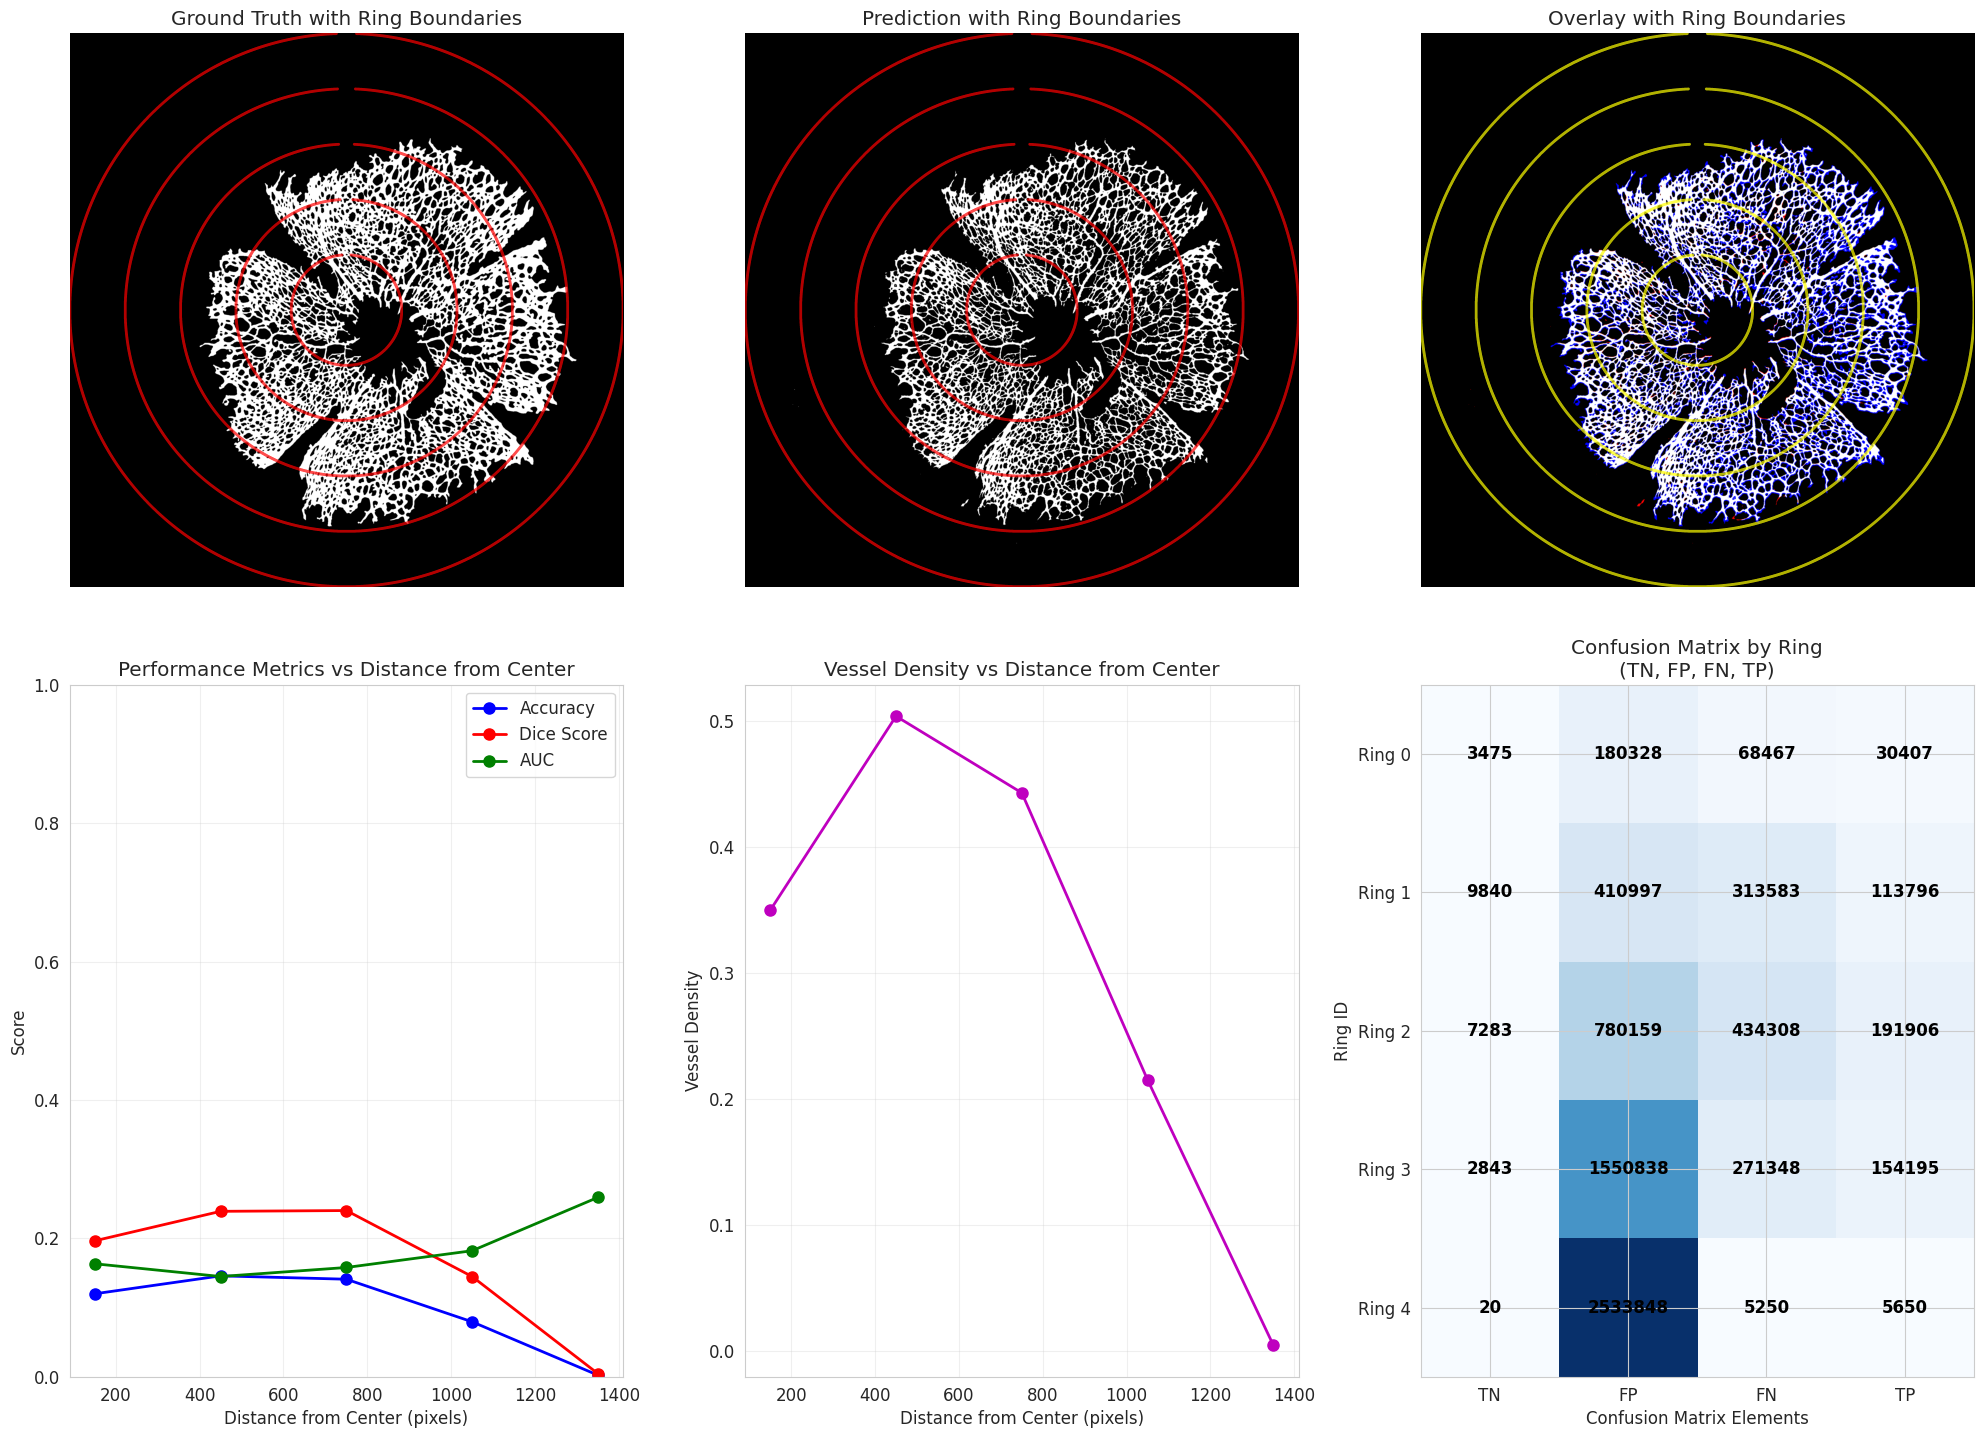


ADDITIONAL ANALYSIS
Correlation between Dice Score and Vessel Density: 0.981
Correlation between Dice Score and Distance from Center: -0.773

Performance by Ring Region:
Region          Avg Dice   Avg AUC    Vessel Density 
--------------------------------------------------
Inner (0-1)     0.218      0.154      0.427          
Middle (1-3)    0.192      0.170      0.329          
Outer (3+)      0.075      0.221      0.110          

RING-BASED EVALUATION COMPLETE


In [30]:
ground_truth_path = '/home/ygao130/Auto/STOR674/Data/validation_data/ground_truth/N 129 groundtruth_converted.tif'
prediction_path = '/home/ygao130/Auto/STOR674/Data/validation_data/feature_extraction/img/N_129_predicted.tif'

# Visualize the ring-based evaluation results
print("\nGenerating comprehensive visualization...")
visualize_ring_evaluation(gt_mask, pred_mask, ring_masks, ring_info, results, 
                         save_path='/home/ygao130/Auto/STOR674/results')

# Additional analysis: Performance correlation with vessel density
print("\n" + "="*60)
print("ADDITIONAL ANALYSIS")
print("="*60)

# Calculate correlation between performance and vessel density
dice_scores = [r['dice_score'] for r in results]
vessel_densities = [r['vessel_density'] for r in results]
distances = [r['center_distance'] for r in results]

correlation_dice_density = np.corrcoef(dice_scores, vessel_densities)[0,1]
correlation_dice_distance = np.corrcoef(dice_scores, distances)[0,1]

print(f"Correlation between Dice Score and Vessel Density: {correlation_dice_density:.3f}")
print(f"Correlation between Dice Score and Distance from Center: {correlation_dice_distance:.3f}")

# Performance by ring region
print(f"\nPerformance by Ring Region:")
print(f"{'Region':<15} {'Avg Dice':<10} {'Avg AUC':<10} {'Vessel Density':<15}")
print("-" * 50)

# Group rings into regions (inner, middle, outer)
inner_rings = [r for r in results if r['ring_id'] < 2]
middle_rings = [r for r in results if 1 < r['ring_id'] < 4]
outer_rings = [r for r in results if r['ring_id'] >= 3]

regions = [
    ("Inner (0-1)", inner_rings),
    ("Middle (1-3)", middle_rings),
    ("Outer (3+)", outer_rings)
]

for region_name, region_results in regions:
    if region_results:
        avg_dice = np.mean([r['dice_score'] for r in region_results])
        avg_auc = np.mean([r['auc'] for r in region_results])
        avg_density = np.mean([r['vessel_density'] for r in region_results])
        print(f"{region_name:<15} {avg_dice:<10.3f} {avg_auc:<10.3f} {avg_density:<15.3f}")

print("\n" + "="*60)
print("RING-BASED EVALUATION COMPLETE")
print("="*60)
